In [19]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
sys.path.append('../')

from util import *
from fico_util import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Define a model for the study of long-term impact of fairness contraints in FICO

### Initial qualification rates 
The qualification rates are $\alpha^0=0.34$ and  $\alpha^1=0.76$.  
The demographic proportions are $P(S=0)=0.12$ and $P(S=1)=0.88$.

In [20]:
P_C = 0.88
P_AA = 0.12
alpha_aa_ini=0.34
alpha_c_ini=0.76

In [21]:
a_c0=1.22
b_c0=13.25
a_c1=2.12
b_c1=1.16
a_aa0= a_c0
b_aa0= b_c0
a_aa1= a_c1
b_aa1= b_c1
# a_aa0=1.18
# b_aa0=16.96
# a_aa1=1.81
# b_aa1=2.26

### Transition probability 
-  $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$, represented by an array T[ y, a, s]: the probability to be qualified given the current qualification state $Y_t=y$, decision $A_t = a$, and the group $S=s$, i.e.,
- The following defined transition is under Condition 1(ii) in the paper.


In [29]:
# Define the transition matrix under Condition 1(ii)
# The order of index in T: 
# ["qualification state", "decision", "group"]
T = np.zeros((2, 2, 2))

T[0,0,0] = 0.1 # "AA"
T[0,1,0] = 0.3
T[1,0,0] = 0.6
T[1,1,0] = 0.9

T[0,0,1] = 0.4  # C
T[0,1,1] = 0.6
T[1,0,1] = 0.4
T[1,1,1] = 0.8

### Dynamics
$\alpha^s_{t+1} = g^{0s}_t + (g^{1s}_t-g^{0s}_t) \alpha^s_t$.  
- $g^{0s}_t = T[0,0,s]\mathbb{E}_{X\mid 0,s}(\hat{Y} = 0) + T[0,1,s] \mathbb{E}_{X\mid 0,s}(\hat{Y} = 1)$  
- $g^{1s}_t = T[1,0,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 0) + T[1,1,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 1)$
- T[ y, a, s] represents $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$.  
- E[ y, a, s] represents $\mathbb{E}_{X\mid y,s}(\hat{Y} = a)$.

In [30]:
def update(alpha,tpr,fpr,T, group):
    g0 = T[0,0,group]*(1-fpr[group]) + T[0,1,group]*fpr[group]
    g1 = T[1,0,group]*(1-tpr[group]) + T[1,1,group]*tpr[group]
    return alpha*g1 + (1-alpha)*g0

In [31]:
def balance_diff(alpha,tpr,fpr,T, group):
    g0 = T[0,0,group]*(1-fpr[group]) + T[0,1,group]*fpr[group]
    g1 = T[1,0,group]*(1-tpr[group]) + T[1,1,group]*tpr[group]    
    return g0 + (g1-g0-1)*alpha 

### The evolution trajectory of qualification rates   

In this study, we consider the demographic invariant generation case. The generation distribution is not changed over time, but the ratio of different subgroups is changed, i.e., the qualification rate. Therefore, we can use resampling to get the dataset at each time step.

*The algorithm:*
1. Compute the ratio for each subgroup;  
2. Sample from the original dataset according to the subgroup-wised ratio;  
3. Apply a classifier to estimating the decision boundary;
4. Apply the dynamics to compute the ratio in next time step.
 

In [32]:
def update_qualification_rates(alpha_aa, alpha_c, T, policy,
                               fn=None, Pf_aa=None, Pf_c=None,
                               paa=P_AA, pc=P_C,
                               a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                               a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1):
    
    tpr,fpr = eva_classifier_fn(alpha_aa,alpha_c, policy,fn, Pf_aa, Pf_c,
                             paa, pc,
                             a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                             a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1)  
    
    alpha_aa_next = update(alpha_aa,tpr,fpr,T,group = 0)
    alpha_c_next = update(alpha_c,tpr,fpr,T,group = 1)
    return alpha_aa_next,alpha_c_next

In [33]:
def compute_balance_diff(alpha_aa, alpha_c, T, policy,
                         fn=None, Pf_aa=None, Pf_c=None,
                         paa=P_AA, pc=P_C,
                         a_aa0=a_aa0,b_aa0=b_aa0,a_aa1=a_aa1,b_aa1=b_aa1,
                         a_c0=a_c0,b_c0=b_c0,a_c1=a_c1,b_c1=b_c1):
    
    tpr,fpr = eva_classifier_fn(alpha_aa,alpha_c,policy,fn, Pf_aa, Pf_c,
                             paa,pc,
                             a_aa0,b_aa0,a_aa1,b_aa1,
                             a_c0,b_c0,a_c1,b_c1)    
    group0 = balance_diff(alpha_aa,tpr,fpr,T,group=0)
    group1 = balance_diff(alpha_c,tpr,fpr,T,group=1)
    return group0, group1

### Evolution behavior in the UN case
**Evolution behavior.** From one sample result, we can see the evolution behavior. The figure indicates that in the UN case, qualification rates converge to an unique equiibria.

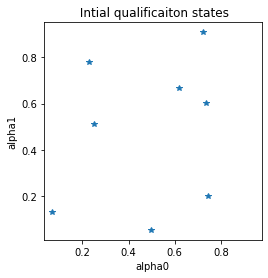

In [34]:
# Define the start point of qualification rates
np.random.seed(10)

NUM_SAMPLES = 8
P0 = 0.8
alpha0List = np.random.uniform(0.05,0.95,NUM_SAMPLES)
alpha1List = np.random.uniform(0.05,0.95,NUM_SAMPLES)


plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(alpha0List,alpha1List,'*',label='Initial points')

plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.axis('square')
plt.title(" Intial qualificaiton states")
plt.show()

7

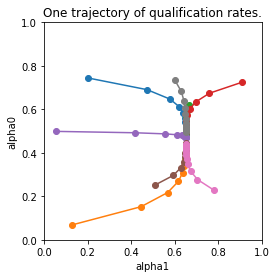

In [35]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()
for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'UN')
        alpha0_un_evolution.append(alpha0)
        alpha1_un_evolution.append(alpha1)

    plt.axis('square')
    plt.plot(alpha1_un_evolution,alpha0_un_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.xlabel('alpha1')
plt.ylabel('alpha0')
plt.title("One trajectory of qualification rates.")
plt.show()



**Balanced curves and evolution behavior.**

In [13]:
TOTAL_STEP = 10
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_UN = np.zeros([len(alphaList),len(alphaList)])
group1_UN = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    for j, alpha1 in enumerate(alphaList):
        sys.stdout.write("\r{0}%".format(str((i*TOTAL_STEP + j)*100/(TOTAL_STEP*TOTAL_STEP))))
        group0_UN[i,j],group1_UN[i,j] = compute_balance_diff(alpha0,alpha1,T,'UN')


99.0%

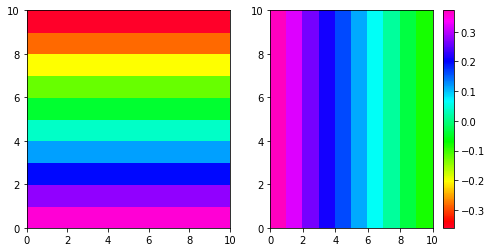

In [14]:
vmin=np.min([group0_UN,group1_UN])
vmax=z_max=np.max([group0_UN,group1_UN])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

### The EqOpt case


7

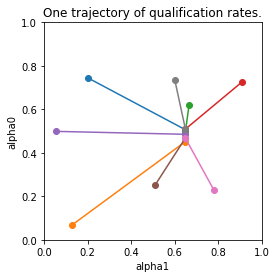

In [36]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()
for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'EqOpt',f_eqopt, Peqopt_aa, Peqopt_c,
                                                    paa=P_AA, pc=P_C,
                                                    a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                                                    a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1
                                                   )
    alpha0_eqopt_evolution.append(alpha0)
    alpha1_eqopt_evolution.append(alpha1)  
    plt.axis('square')
    plt.plot(alpha1_eqopt_evolution,alpha0_eqopt_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.xlabel('alpha1')
plt.ylabel('alpha0')
plt.title("One trajectory of qualification rates.")
plt.show()




**Balanced curves and evolution behavior.**

In [308]:
TOTAL_STEP = 10
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_eqopt = np.zeros([len(alphaList),len(alphaList)])
group1_eqopt = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    for j, alpha1 in enumerate(alphaList):
        sys.stdout.write("\r{0}%".format(str((i*TOTAL_STEP + j)*100/(TOTAL_STEP*TOTAL_STEP))))
        group0_eqopt[i,j],group1_eqopt[i,j] = compute_balance_diff(alpha0,alpha1,T,'EqOpt', f_eqopt, Peqopt_aa, Peqopt_c,)


0.0%

invalid value encountered in double_scalars


99.0%

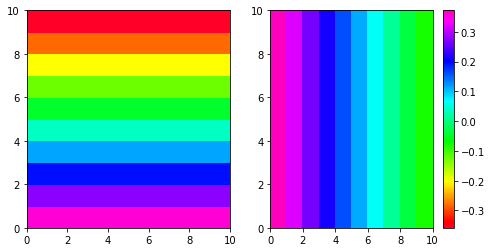

In [17]:
vmin=np.min([group0_UN,group1_UN])
vmax=z_max=np.max([group0_UN,group1_UN])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_UN, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

### The EO case


7

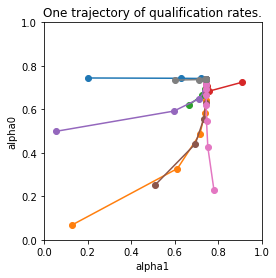

In [37]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()
for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eo_evolution=[alpha0]
    alpha1_eo_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'EO',f_eo, Peo_aa, Peo_c,
                                                    paa=P_AA, pc=P_C,
                                                    a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                                                    a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1
                                                   )
        alpha0_eo_evolution.append(alpha0)
        alpha1_eo_evolution.append(alpha1)  
        
    plt.axis('square')
    plt.plot(alpha1_eo_evolution,alpha0_eo_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.xlabel('alpha1')
plt.ylabel('alpha0')
plt.title("One trajectory of qualification rates.")
plt.show()

**Balanced curves and evolution behavior.**

In [75]:
TOTAL_STEP = 10
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_eo = np.zeros([len(alphaList),len(alphaList)])
group1_eo = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    for j, alpha1 in enumerate(alphaList):
        sys.stdout.write("\r{0}%".format(str((i*TOTAL_STEP + j)*100/(TOTAL_STEP*TOTAL_STEP))))
        group0_eo[i,j],group1_eo[i,j] = compute_balance_diff(alpha0,alpha1,T,'EqOpt', f_eo, Peo_aa, Peo_c,)


99.0%

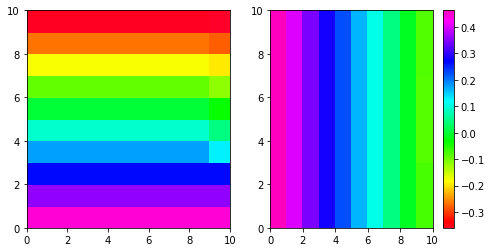

In [76]:
vmin=np.min([group0_eo,group1_eo])
vmax=z_max=np.max([group0_eo,group1_eo])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_eo, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_eo, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

### The DP case

**Evolution behavior.**

7

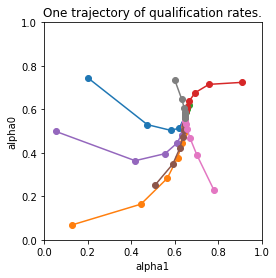

In [38]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 10
plt.figure()
for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    for _ in range(MAX_ITERATION_EQUILIBRIUM):
        alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'DP',f_dp, Pdp_aa, Pdp_c,
                                                    paa=P_AA, pc=P_C,
                                                    a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                                                    a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1
                                                   )
        alpha0_dp_evolution.append(alpha0)
        alpha1_dp_evolution.append(alpha1)  


        
    plt.axis('square')
    plt.plot(alpha1_dp_evolution,alpha0_dp_evolution,'o-')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.xlabel('alpha1')
plt.ylabel('alpha0')
plt.title("One trajectory of qualification rates.")
plt.show()

In [66]:
TOTAL_STEP = 10
alphaList = np.linspace(0.05,0.95,TOTAL_STEP)

group0_dp = np.zeros([len(alphaList),len(alphaList)])
group1_dp = np.zeros([len(alphaList),len(alphaList)])

for i, alpha0 in enumerate(alphaList):
    for j, alpha1 in enumerate(alphaList):
        sys.stdout.write("\r{0}%".format(str((i*TOTAL_STEP + j)*100/(TOTAL_STEP*TOTAL_STEP))))
        group0_dp[i,j],group1_dp[i,j] = compute_balance_diff(alpha0,alpha1,T,'DP',f_dp, Pdp_aa, Pdp_c)



99.0%

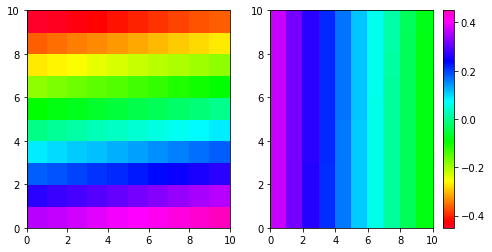

In [70]:
vmin=np.min([group0_dp,group1_dp])
vmax=z_max=np.max([group0_dp,group1_dp])

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(8, 4))

im0 = ax0.pcolormesh(group0_dp, cmap='gist_rainbow',vmin=vmin,vmax=vmax)
im1= ax1.pcolormesh(group1_dp, cmap='gist_rainbow',vmin=vmin,vmax=vmax)

fig.colorbar(im1, ax=ax1)
plt.show()

## Long-term impact of fairness constraints
It turns out that under Condition 1(ii),  
- Fairness constraints promote the equality.
- DP and EO help increase the overall qualification rate, whereas EqOpt decreases it.

In [39]:
print('The equality measure of UN: ', alpha0_un_evolution[-1]-alpha1_un_evolution[-1])
print('The equality measure of DP: ', alpha0_dp_evolution[-1]-alpha1_dp_evolution[-1])
print('The equality measure of EO: ', alpha0_eo_evolution[-1]-alpha1_eo_evolution[-1])
print('The equality measure of EqOpt: ', alpha0_eqopt_evolution[-1]-alpha1_eqopt_evolution[-1])

The equality measure of UN:  -0.15511029190565212
The equality measure of DP:  -0.08605536335182373
The equality measure of EO:  -0.004816366329783883
The equality measure of EqOpt:  -0.14254742460592396


In [40]:
print('The overall qualification rate measure of UN: ', alpha0_un_evolution[-1]+alpha1_un_evolution[-1])
print('The overall qualification rate measure of DP: ', alpha0_dp_evolution[-1]+alpha1_dp_evolution[-1])
print('The overall qualification rate measure of EO: ', alpha0_eo_evolution[-1]+alpha1_eo_evolution[-1])
print('The overall qualification rate measure of EqOpt: ', alpha0_eqopt_evolution[-1]+alpha1_eqopt_evolution[-1])

The overall qualification rate measure of UN:  1.1476672121629867
The overall qualification rate measure of DP:  1.2103627738008036
The overall qualification rate measure of EO:  1.4859608476631312
The overall qualification rate measure of EqOpt:  1.1580941100048034
